### Create dataset

In [22]:
import numpy as np
from src.synthetic_causal_graphs import CausalGraph
from src.utils import fitness
import matplotlib.pyplot as plt

# Define parameters for CausalGraph
n_nodes = 20  # number of nodes
p = 0.2  # edge probability
seed = 42
graph_type = 'ER'
sem_type = 'mlp'  # Multi-layer perceptron with additive noise
w_ranges = ((-2.0, -0.5), (0.5, 2.0)) 

# Depending on number of nodes and edge probability, the generated random DAG might comprise several disconnected components.
# This is generally not desirable so the CausalGraph class checks if the DAG is weakly connected. 
max_attempts = 10  # Set the maximum number of attempts to create a weakly connected graph

# Try to create a weakly connected CausalGraph
for attempt in range(max_attempts):
    try:
        # Generate the CausalGraph
        model = CausalGraph(n_nodes, p, graph_type, sem_type, w_ranges, seed=seed)
        break  # Exit the loop if successful
    except AssertionError as e:
        print(f"Attempt {attempt + 1} failed: {e}")
else:
    raise RuntimeError(f"Failed to create a weakly connected CausalGraph after {max_attempts} attempts")


Visualization of generated DAG. The arrows show the flow of causality from parent nodes to their descendants. SEM weights not shown.


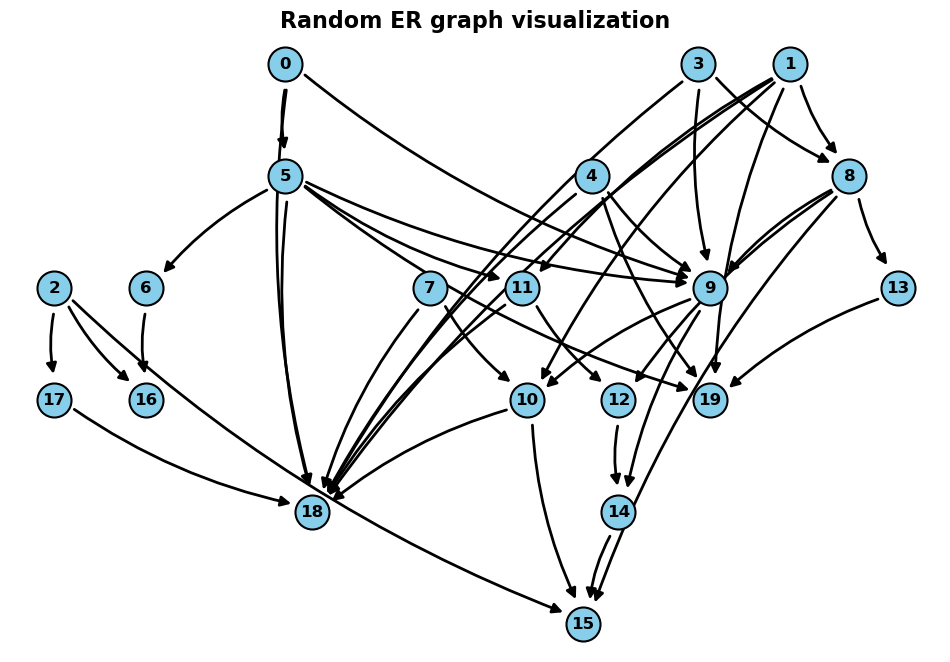

In [23]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
import numpy as np

def plot_network(causal_graph: CausalGraph) -> None:
    """
    Plot a CausalGraph object using NetworkX and Matplotlib.

    :param causal_graph: A CausalGraph object to be plotted.
    :return: None
    """
    # Convert the CausalGraph model to a NetworkX DiGraph
    G = causal_graph.model

    # Set the positions of the nodes for visualization using the 'dot' layout algorithm
    pos = graphviz_layout(G, prog='dot')

    # Draw the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))

    # Draw the nodes
    node_options = {
        "node_size": 600,
        "node_color": "skyblue",
        "edgecolors": "black",
        "linewidths": 1.5,
    }
    nx.draw_networkx_nodes(G, pos, ax=ax, **node_options)

    # Draw the node labels
    label_options = {
        "font_size": 12,
        "font_weight": "bold",
    }
    nx.draw_networkx_labels(G, pos, ax=ax, **label_options)

    # Draw the edges manually using FancyArrowPatch
    for edge in G.edges():
        start_pos = np.array(pos[edge[0]])
        end_pos = np.array(pos[edge[1]])
        direction = end_pos - start_pos
        direction_norm = direction / np.linalg.norm(direction)
        node_radius = 15 
        start_pos_adjusted = start_pos + node_radius * direction_norm
        end_pos_adjusted = end_pos - node_radius * direction_norm
        arrow = FancyArrowPatch(
            start_pos_adjusted, end_pos_adjusted, arrowstyle='-|>', color='black',
            mutation_scale=15, linewidth=2, connectionstyle="arc3,rad=0.1"
        )
        ax.add_patch(arrow)

    # Set the plot title and remove the axis
    ax.set_title("Random ER graph visualization", fontsize=16, fontweight='bold')
    ax.axis('off')

    # Show the plot
    plt.show()

# Assuming 'model' is your CausalGraph instance
plot_network(model)
print("Visualization of generated DAG. The arrows show the flow of causality from parent nodes to their descendants. SEM weights not shown.")


### Sampling observational data

In [25]:
noise_scale = 1.0
n_samples = 1000

# Simulate SEM to generate samples
X = model.simulate_sem(n_samples, noise_scale=noise_scale)

print("X Shape: (n_samples, n_nodes): ", X.shape)  # The columns follow the topological order of the nodes, that is 0, 1, 2,...n_nodes-1.

X Shape: (n_samples, n_nodes):  (1000, 20)


### Performing interventions

In [26]:
# Simulate data with an intervention on node 10, setting its value to 0
# Shape of X_intervened is (n_samples, n_nodes). The columns follow the topological order of the nodes, that is 0, 1, 2,...n_nodes-1.
intervened_value = 0
intervened_node = 10
X_intervened = model.simulate_sem(n_samples=n_samples, intervened_node=intervened_node, intervened_value=intervened_value, noise_scale=noise_scale)

When we set node 10 to 0, it directly changes its value. An ancestor node remains unaffected because it's upstream in the causal graph, so its distribution doesn't change. However, a descendant node's distribution shifts because it's downstream and directly influenced by node 10. 


The simulate_sem method in CausalGraph class achieves the effect of consistent counterfactual comparisons by using a controlled random seed generator. This ensures that the same random processes (such as noise generation and weight assignment) are used for both the observational and interventional datasets.


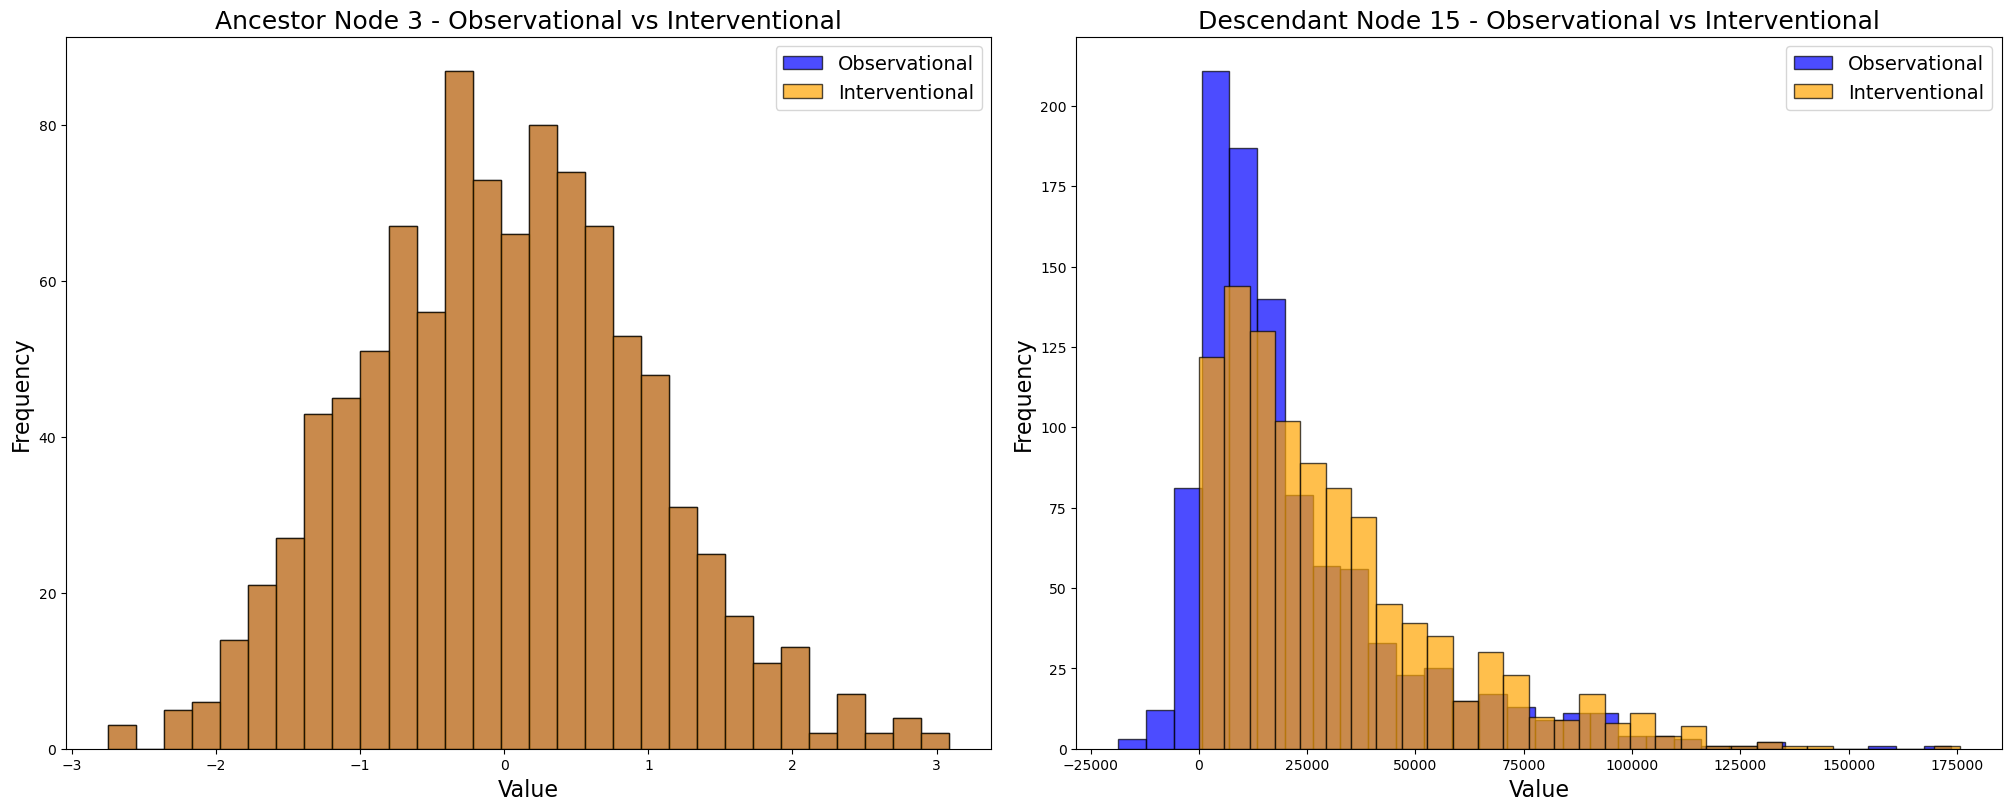

In [27]:
ancestor_node = 3  # Intervened on node 10
descendant_node = 15

# Plot the observational vs interventional data for the ancestor and descendant nodes
fig, axs = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

# Ancestor data plot
axs[0].hist(X[:, ancestor_node], bins=30, color='blue', alpha=0.7, label='Observational', edgecolor='black')
axs[0].hist(X_intervened[:, ancestor_node], bins=30, color='orange', alpha=0.7, label='Interventional', edgecolor='black')
axs[0].set_xlabel('Value', fontsize=16)
axs[0].set_ylabel('Frequency', fontsize=16)
axs[0].set_title(f'Ancestor Node {ancestor_node} - Observational vs Interventional', fontsize=18)
axs[0].legend(fontsize=14)

# Descendant data plot
axs[1].hist(X[:, descendant_node], bins=30, color='blue', alpha=0.7, label='Observational', edgecolor='black')
axs[1].hist(X_intervened[:, descendant_node], bins=30, color='orange', alpha=0.7, label='Interventional', edgecolor='black')
axs[1].set_xlabel('Value', fontsize=16)
axs[1].set_ylabel('Frequency', fontsize=16)
axs[1].set_title(f'Descendant Node {descendant_node} - Observational vs Interventional', fontsize=18)
axs[1].legend(fontsize=14)

plt.show()

print(f"When we set node {intervened_node} to 0, it directly changes its value. An ancestor node remains unaffected because it's upstream in the causal graph, so its distribution doesn't change. However, a descendant node's distribution shifts because it's downstream and directly influenced by node {intervened_node}. ")
print("\n")
print("The simulate_sem method in CausalGraph class achieves the effect of consistent counterfactual comparisons by using a controlled random seed generator. This ensures that the same random processes (such as noise generation and weight assignment) are used for both the observational and interventional datasets.")



### Calculate causal effect of intervention

In [61]:
# Calculate fitness
fitness_obs, sampled_indices_obs, theta_obs = fitness(X, noise_std=0.1, proportion=0.1, seed=seed, strategy='last_few')
fitness_int, sampled_indices_int, theta_int = fitness(X_intervened, noise_std=0.1, proportion=0.1, seed=seed, strategy='last_few')

print("Fitness Values Shape: (n_samples,): ", fitness_obs.shape)  # A fitness value for each sample
print("Sampled Indices (parent nodes of outcome):", sampled_indices_obs)  # Node indices which act as parents of the fitness outcome
print("Theta (Fitness Weights):", theta_obs)  # Associated weights with fitness function
print("\n")

# The causal parents and their weights must match between the observational and interventional fitness outcome calculations.
assert (sampled_indices_obs == sampled_indices_int).all()
assert (theta_obs == theta_int).all()

# Calculate the causal effect of the intervention
ATE = np.mean(fitness_int - fitness_obs)
print(f"Average Causal Effect of Intervention: {ATE}")

Fitness Values Shape: (n_samples,):  (1000,)
Sampled Indices (parent nodes of outcome): [18 19]
Theta (Fitness Weights): [-1.34168234  0.64126602]


Average Causal Effect of Intervention: -14340.75517544518


In [62]:
# Draft Explanation

# 1. Each sample in the interventional dataset is a counterfactual of a matched observational sample
# answering the question: what would happen if we set the value of node 10 to 0.

print("Each sample in the interventional dataset is a counterfactual of a matched observational sample,")
print("answering the question: what would happen if we set the value of node 10 to 0.")

# 2. This allows us to calculate the causal effect directly by using:
#    E[Y(do(node 10)=0) - Y_obs] = (1 / n_samples) * sum_{k=1}^{n_samples} [Y(do(node 10)=0, k) - Y_obs, k]

print("This allows us to calculate the causal effect directly by using:")
print("E[Y(do(node 10)=0) - Y_obs] = (1 / n_samples) * sum_{k=1}^{n_samples} [Y(do(node 10)=0, k) - Y_obs, k]")


Each sample in the interventional dataset is a counterfactual of a matched observational sample,
answering the question: what would happen if we set the value of node 10 to 0.
This allows us to calculate the causal effect directly by using:
E[Y(do(node 10)=0) - Y_obs] = (1 / n_samples) * sum_{k=1}^{n_samples} [Y(do(node 10)=0, k) - Y_obs, k]
